# Pytorch

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

## Dataset
---

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim

import torch
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

# Define the data transformations
transform = transforms.Compose([
    #transforms.Resize((512, 512)),
    transforms.Resize((256, 256)),
    #transforms.Resize((28, 28)),
    # transforms.RandomHorizontalFlip(),
    # transforms.RandomRotation(10),
    transforms.ToTensor(),
])

# Load the image and label datasets
train_dataset = ImageFolder('train/images/', transform=transform)
label_dataset = ImageFolder('train/labels/', transform=transform)
test_dataset = ImageFolder('test', transform=transform)

# Combine the image and label datasets
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, image_dataset, label_dataset):
        self.image_dataset = image_dataset
        self.label_dataset = label_dataset
    
    def __getitem__(self, index):
        # Get the input and label images
        input_image, _ = self.image_dataset[index]
        label_image, _ = self.label_dataset[index]
        
        # Return the input and label images
        return input_image, label_image
    
    def __len__(self):
        # Return the length of the dataset
        return len(self.image_dataset)

# Create a custom dataset
custom_dataset = CustomDataset(train_dataset, label_dataset)

# Create a data loader for the custom dataset
batch_size = 16
train_iter = DataLoader(custom_dataset, batch_size=batch_size, shuffle=True)
test_iter = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

## Model
---

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])

        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=False):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = (DoubleConv(n_channels, 64))
        self.down1 = (Down(64, 128))
        self.down2 = (Down(128, 256))
        self.down3 = (Down(256, 512))
        factor = 2 if bilinear else 1
        self.down4 = (Down(512, 1024 // factor))
        self.up1 = (Up(1024, 512 // factor, bilinear))
        self.up2 = (Up(512, 256 // factor, bilinear))
        self.up3 = (Up(256, 128 // factor, bilinear))
        self.up4 = (Up(128, 64, bilinear))
        self.outc = (OutConv(64, n_classes))

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits

    def use_checkpointing(self):
        self.inc = torch.utils.checkpoint(self.inc)
        self.down1 = torch.utils.checkpoint(self.down1)
        self.down2 = torch.utils.checkpoint(self.down2)
        self.down3 = torch.utils.checkpoint(self.down3)
        self.down4 = torch.utils.checkpoint(self.down4)
        self.up1 = torch.utils.checkpoint(self.up1)
        self.up2 = torch.utils.checkpoint(self.up2)
        self.up3 = torch.utils.checkpoint(self.up3)
        self.up4 = torch.utils.checkpoint(self.up4)
        self.outc = torch.utils.checkpoint(self.outc)

model = nn.Sequential(
    UNet(3, 3), 
)

# 定义损失函数和优化器
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



## Train
---

In [ ]:
# 加载数据集并进行训练
epochs = 10
for epoch in range(epochs):
    for i, (images, labels) in enumerate(train_iter):
        # 前向传播
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # # 每4次迭代打印一次信息
        # if (i+1) % 4 == 0:
        #     
    #print(epoch, loss.item())
    print('Epoch [{}/{}], Iteration [{}/{}], Loss: {:.4f}'.\
          format(epoch+1, epochs, i+1, len(train_iter), loss.item()))

In [ ]:

torch.save(model, 'model.pth')
# 定义字典，将模型、优化器和其他变量存储起来
checkpoint = {
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'epoch': epochs,
    # 'loss': losses,
}

# 保存模型和优化器
torch.save(checkpoint, 'checkpoint.pth')

In [4]:
model = torch.load('model.pth')

## Test
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


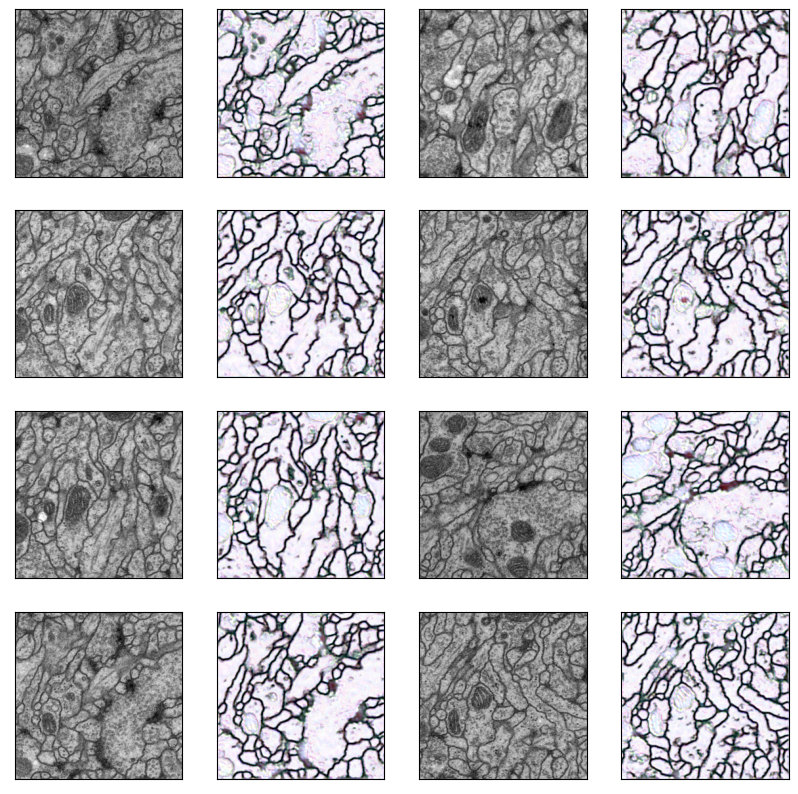

In [5]:
import matplotlib.pyplot as plt

X, y = next(iter(test_iter))
yy = model(X)

fig, ax = plt.subplots(figsize=(10, 10), nrows=4, ncols=4)
ax = ax.flatten()
for i in range(0, 16, 2):
    ax[i].imshow(X[i].permute(1, 2, 0))
    ax[i].axes.get_xaxis().set_visible(False) 
    ax[i].axes.get_yaxis().set_visible(False)
    # 将数据进行转置，使得通道维度在最后一个维度上
    ax[i+1].imshow(yy[i].permute(1, 2, 0).detach().numpy())
    ax[i+1].axes.get_xaxis().set_visible(False)
    ax[i+1].axes.get_yaxis().set_visible(False)


In [ ]:
import torchvision

# Test
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
test_iter = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=False, num_workers=2)

text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 
                'coat', 'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']

         
j = 12

X, y = next(iter(test_iter))
XX = torch.cat((X[j], X[j], X[j]), dim=0)
y = XX.reshape(1, XX.shape[0], XX.shape[1], XX.shape[2])
y = torch.cat((y, y, y), dim=0)
yy = model(y)

fig, ax = plt.subplots(figsize=(10, 10), nrows=1, ncols=2)
ax = ax.flatten()
ax[0].imshow(X[j].reshape(X[j].shape[1], X[j].shape[2]).detach().numpy())
ax[1].imshow(yy[0][0].detach().numpy())

# Tensorflow

### MNIST

In [2]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

mnist = datasets.mnist

(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train / 255.0
x_test = x_test / 255.0

x_train = tf.expand_dims(x_train, axis=-1)
y_train = tf.expand_dims(y_train, axis=-1)

x_test = tf.expand_dims(x_test, axis=-1)
y_test = tf.expand_dims(y_test, axis=-1)

dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).shuffle(10000).batch(32)

In [ ]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

class MyModel(Model):
    def __init__(self):
        super(MyModel, self).__init__()
        self.conv11 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv12 = Conv2D(32, 3, activation='relu', padding='same')

        self.maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv21 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv22 = Conv2D(64, 3, activation='relu', padding='same')

        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2)) 
        self.conv31 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv32 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv33 = Conv2D(128, 3, activation='relu', padding='same')

        self.up2 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat2 = tf.keras.layers.Concatenate(axis=3)
        self.convup21 = Conv2D(64, 3, activation='relu', padding='same')
        self.convup22 = Conv2D(64, 3, activation='relu', padding='same')

        self.up1 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat1 = tf.keras.layers.Concatenate(axis=3)
        self.convup11 = Conv2D(32, 3, activation='relu', padding='same')
        self.convup12 = Conv2D(32, 3, activation='relu', padding='same')

        self.flatten = Flatten()
        self.d1 = Dense(128, activation='relu')
        self.d2 = Dense(10)
        self.s1 = tf.keras.layers.Softmax()

    def call(self, x):
        x = self.conv11(x)
        x = self.conv12(x)
        x1 = x      # 28x28x32

        x = self.maxpool1(x) # 14x14x32
        x = self.conv21(x)
        x = self.conv22(x)   # 14x14x64
        x2 = x

        x = self.maxpool2(x) # 7x7x64
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)   # 7x7x128

        up2 = self.up2(x)    # 14x14x64
        x = self.concat2([x2, up2]) 
        x = self.convup21(x)   
        x = self.convup22(x)  

        up1 = self.up1(x)    # 28x28x32
        x = self.concat1([x1, up1])
        x = self.convup11(x)
        x = self.convup12(x) 
        
        x = self.flatten(x)
        x = self.d1(x)
        x = self.d2(x)
        x = self.s1(x)
        return x

# Create an instance of the model
model = MyModel()

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(train_dataset, epochs=50)

In [ ]:
i = 189

yy = model.predict(tf.expand_dims(x_test[i], axis=0))
yy[-1].argmax(), y_test[i], yy.shape

### CAE fig-fig

#### Dataset

In [ ]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

from tensorflow.keras.utils import Sequence

def data_generator():
    path_images = './train/images/image/'
    path_labels = './train/labels/label/'

    files_images = os.listdir(path_images)
    files_images.sort()
    files_labels = os.listdir(path_labels)
    files_labels.sort()

    images = []
    labels = []
    for X, y in zip(files_images, files_labels):
        image = np.array(Image.open(path_images + X).convert('RGB'))
        label = np.array(Image.open(path_labels + y).convert('RGB'))
        images.append(image)
        labels.append(label)
    return images, labels

images, labels = data_generator()
images = tf.constant(images)
labels = tf.constant(labels)
images = tf.cast(images, tf.float32)
labels = tf.cast(labels, tf.float32)
images = images[:, ::4, ::4, :]/255.0
labels = labels[:, ::4, ::4, :]/255.0
# images = images/255.0
# labels = labels/255.0

batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(10000).batch(batch_size)


#### Model

In [7]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D, concatenate, UpSampling2D, MaxPooling2D


input = tf.keras.Input(shape=(128, 128, 3))
x = Conv2D(32, 3, activation='relu', padding='same')(input) 
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x1 = x      # 512x512x32
x = MaxPooling2D((2, 2))(x) # 256x256x32
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x2 = x      # 256x256x64
x = MaxPooling2D((2, 2))(x) # 128x128x64
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x3 = x      # 128x128x128
x = MaxPooling2D((2, 2))(x) # 64x64x128
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = Conv2D(256, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 128x128x256
x = concatenate([x3, x])    # 128x128x384
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = Conv2D(128, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 256x256x128
x = concatenate([x2, x])    # 256x256x192
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = Conv2D(64, 3, activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x) # 512x512x64
x = concatenate([x1, x])    # 512x512x96
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = Conv2D(32, 3, activation='relu', padding='same')(x)
x = Conv2D(3, 3, activation='relu', padding='same')(x)
x = Conv2D(3, 1, activation='relu', padding='same')(x)

model = Model(inputs=input, outputs=x)


#### Train

In [14]:
model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
model.fit(train_dataset, epochs=500)
model.save('unet_fig2fig.h5')

Epoch 1/500
2/2 [==============================] - 13s 943ms/step - loss: 0.7778 - accuracy: 0.9972
Epoch 2/500
2/2 [==============================] - 0s 29ms/step - loss: 0.7485 - accuracy: 0.9998
Epoch 3/500
2/2 [==============================] - 0s 28ms/step - loss: 27.6547 - accuracy: 0.9821
Epoch 4/500
2/2 [==============================] - 0s 29ms/step - loss: 0.5298 - accuracy: 0.9865
Epoch 5/500
2/2 [==============================] - 0s 29ms/step - loss: 0.7199 - accuracy: 0.9996
Epoch 6/500
2/2 [==============================] - 0s 30ms/step - loss: 0.7478 - accuracy: 0.9999
Epoch 7/500
2/2 [==============================] - 0s 29ms/step - loss: 0.7477 - accuracy: 0.9999
Epoch 8/500
2/2 [==============================] - 0s 42ms/step - loss: 0.7387 - accuracy: 0.9998
Epoch 9/500
2/2 [==============================] - 0s 43ms/step - loss: 0.7203 - accuracy: 0.9990
Epoch 10/500
2/2 [==============================] - 0s 56ms/step - loss: 0.6830 - accuracy: 0.9972
Epoch 11/500
2/2

In [ ]:
model = tf.keras.models.load_model('unet_fig2fig.h5')

In [ ]:
# 创建 FileWriter 对象，指定日志文件的目录
writer = tf.summary.create_file_writer('logs/')

# 在每个训练或评估步骤中，将相关数据写入日志文件
with writer.as_default():
    tf.summary.record_if(True)  # 记录数据到事件文件
    summary = ...  # 获取要记录的数据
    tf.summary.scalar('my_metric', summary, step=)  # 将数据写入日志文件


#### Test

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


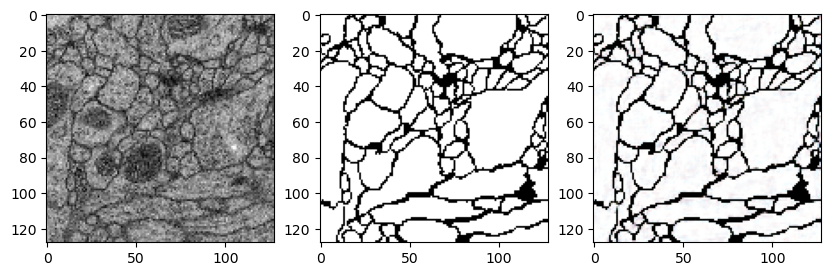

In [17]:
import matplotlib.pyplot as plt

X, y = next(iter(train_dataset))
i= 1

yy = model.predict(tf.expand_dims(X[i], axis=0))
yy.shape

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), nrows=1, ncols=3)
ax1.imshow(X[i])
ax2.imshow(y[i])
ax3.imshow(yy[0])

### CAE fig-fig Class

#### Dataset

In [13]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image

from tensorflow.keras.utils import Sequence

def data_generator():
    path_images = './train/images/image/'
    path_labels = './train/labels/label/'

    files_images = os.listdir(path_images)
    files_images.sort()
    files_labels = os.listdir(path_labels)
    files_labels.sort()

    images = []
    labels = []
    for X, y in zip(files_images, files_labels):
        image = np.array(Image.open(path_images + X).convert('RGB'))
        label = np.array(Image.open(path_labels + y).convert('RGB'))
        images.append(image)
        labels.append(label)
    return images, labels

images, labels = data_generator()
images = tf.constant(images)
labels = tf.constant(labels)
images = tf.cast(images, tf.float32)
labels = tf.cast(labels, tf.float32)
images = images[:, ::4, ::4, :]/255.0
labels = labels[:, ::4, ::4, :]/255.0
# images = images/255.0
# labels = labels/255.0

batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((images, labels)).shuffle(10000).batch(batch_size)


#### Model

In [25]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

class MyModel(Model):
    def __init__(self, input_shape):
        super(MyModel, self).__init__()
        self.conv11 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv12 = Conv2D(32, 3, activation='relu', padding='same')

        self.maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv21 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv22 = Conv2D(64, 3, activation='relu', padding='same')

        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2)) 
        self.conv31 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv32 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv33 = Conv2D(128, 3, activation='relu', padding='same')

        self.up2 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat2 = tf.keras.layers.Concatenate(axis=3)
        self.convup21 = Conv2D(64, 3, activation='relu', padding='same')
        self.convup22 = Conv2D(64, 3, activation='relu', padding='same')

        self.up1 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat1 = tf.keras.layers.Concatenate(axis=3)
        self.convup11 = Conv2D(32, 3, activation='relu', padding='same')
        self.convup12 = Conv2D(32, 3, activation='relu', padding='same')

        self.conva = Conv2D(3, 1, activation='relu', padding='same')


    def call(self, x):

        x = self.conv11(x)
        x = self.conv12(x)
        x1 = x      # 28x28x32

        x = self.maxpool1(x) # 14x14x32
        x = self.conv21(x)
        x = self.conv22(x)   # 14x14x64
        x2 = x

        x = self.maxpool2(x) # 7x7x64
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)   # 7x7x128

        up2 = self.up2(x)    # 14x14x64
        x = self.concat2([x2, up2]) 
        x = self.convup21(x)   
        x = self.convup22(x)  

        up1 = self.up1(x)    # 28x28x32
        x = self.concat1([x1, up1])
        x = self.convup11(x)
        x = self.convup12(x) 

        x = self.conva(x)
        
        return x

# Create an instance of the model
inputs = tf.keras.Input(shape=(128, 128, 3))
model = tf.keras.Model(inputs=inputs, outputs=MyModel(inputs).call(inputs))


#### Train

In [28]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['accuracy'])

# 创建ModelCheckpoint回调函数，用于保存模型
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.h5',  # 模型保存路径
    save_best_only=True,  # 只保存在验证集上表现最好的模型
    monitor='val_accuracy',  # 监控的指标，可以是'val_loss'或其他指标
    mode='max',  # 监控指标的模式，'max'表示越大越好，'min'表示越小越好
    verbose=1  # 显示保存信息
)

# 训练模型
model.fit(train_dataset, epochs=50, callbacks=[checkpoint_callback])

Epoch 1/50
2/2 [==============================] - 1s 30ms/step - loss: 0.1746 - accuracy: 0.6024
Epoch 2/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1328 - accuracy: 0.5473
Epoch 3/50
2/2 [==============================] - 0s 45ms/step - loss: 0.1650 - accuracy: 0.4706
Epoch 4/50
2/2 [==============================] - 0s 41ms/step - loss: 0.1463 - accuracy: 0.5457
Epoch 5/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1271 - accuracy: 0.6062
Epoch 6/50
2/2 [==============================] - 0s 32ms/step - loss: 0.1369 - accuracy: 0.4629
Epoch 7/50
2/2 [==============================] - 0s 40ms/step - loss: 0.1322 - accuracy: 0.2300
Epoch 8/50
2/2 [==============================] - 0s 27ms/step - loss: 0.1252 - accuracy: 0.2119
Epoch 9/50
2/2 [==============================] - 0s 31ms/step - loss: 0.1287 - accuracy: 0.2692
Epoch 10/50
2/2 [==============================] - 0s 28ms/step - loss: 0.1246 - accuracy: 0.2159
Epoch 11/50
2/2 [============

#### Test

2023-08-03 10:47:07.746429: W tensorflow/core/data/root_dataset.cc:163] Optimization loop failed: CANCELLED: Operation was cancelled
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


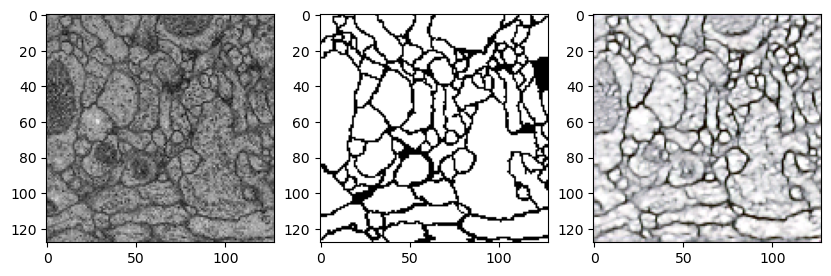

In [33]:
import matplotlib.pyplot as plt

X, y = next(iter(train_dataset))
i= 1

yy = model.predict(tf.expand_dims(X[i], axis=0))
yy.shape

fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), nrows=1, ncols=3)
ax1.imshow(X[i])
ax2.imshow(y[i])
ax3.imshow(yy[0])

In [398]:
from scipy.interpolate import interp2d

X, y = next(iter(dataset))

a = X[0].numpy()
x = np.linspace(0, 28, 28)
y = np.linspace(0, 28, 28)
# X, Y = np.meshgrid(x, y)


# x1 = np.arange(0, 128, 1)
# y1 = np.arange(0, 128, 1)
# X1, Y1 = np.meshgrid(x1, y1)

# f1 = interp2d(X, Y, a[:, :, 0], kind='cubic')
# Z1 = f1(X1, Y1)

x1 = np.linspace(0, 28, 128)
y1 = np.linspace(0, 28, 128)
f2 = interp2d(x, y, a[:, :, 0], kind='cubic')
Z2 = f2(x1, y1)


In [399]:
import numpy as np

ZZ = np.expand_dims(Z2, axis=-1)
Z = np.concatenate((ZZ, ZZ, ZZ), axis=-1)
print(Z.shape)
yy = model.predict(tf.expand_dims(Z, axis=0))

(128, 128, 3)
1/1 [==============================] - 0s 222ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


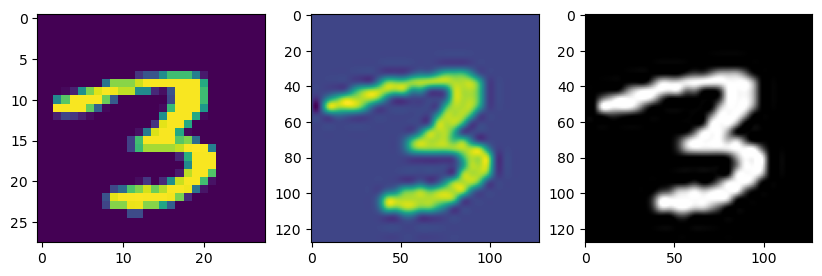

In [401]:
fig, (ax1, ax2, ax3) = plt.subplots(figsize=(10, 10), nrows=1, ncols=3)

ax1.imshow(a[:, :, 0])
ax2.imshow(ZZ)
ax3.imshow(Z)


In [356]:
%load_ext tensorboard

In [ ]:
%tensorboard --logdir ./ --host localhost

In [16]:
!nvidia-smi

Thu Aug  3 10:26:07 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:D8:00.0  On |                  N/A |
| 61%   48C    P8    36W / 370W |   9513MiB / 10240MiB |      9%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Car

In [1]:
import tensorflow as tf
import numpy as np
import os
from PIL import Image
from sklearn.model_selection import train_test_split


from tensorflow.keras.utils import Sequence

In [2]:
path = 'newnpz/'
files = sorted(os.listdir(path))

images = []
labels = []
for file in files:
    data = np.load(os.path.join(path, file))
    images.append(data['raw'])
    labels.append(data['label'])

images = np.array(images, dtype=np.float32)
labels = np.array(labels, dtype=np.float32)

X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=0)


In [3]:
X_train.shape

(7, 60000, 104)

In [4]:
X_train = X_train[..., 20:100]
X_test = X_test[..., 20:100]
y_train = y_train[..., 20:100]
y_test = y_test[..., 20:100]



X_train = X_train[:, ::10, :]
X_test = X_test[:, ::10, :]
y_train = y_train[:, ::10, :]
y_test = y_test[:, ::10, :]


X_train = X_train.reshape(-1, 600, 80, 1)
X_test = X_test.reshape(-1, 600, 80, 1)
y_train = y_train.reshape(-1, 600, 80, 1)
y_test = y_test.reshape(-1, 600, 80, 1)

#y_train[:, 200:400, 20:40] = 1


X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

# 使用 tf.keras.utils.normalize() 对数据集进行归一化
X_train = tf.keras.utils.normalize(X_train, axis=-1)
X_test = tf.keras.utils.normalize(X_test, axis=-1)
y_train = tf.keras.utils.normalize(y_train, axis=-1)
y_test = tf.keras.utils.normalize(y_test, axis=-1)



batch_size = 16
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(batch_size)

In [7]:
X_train.shape

TensorShape([110, 600, 80, 1])

In [6]:
y_train[10].numpy().max()

1.0

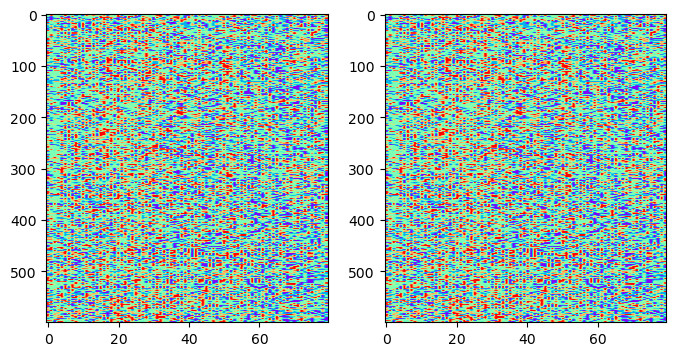

In [18]:
import matplotlib.pyplot as plt

i = 22

vmin1 = np.min(X_train[i])
vmax1 = np.max(X_train[i])
vmin2 = np.min(y_train[i])
vmax2 = np.max(y_train[i])
scale = 1.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (8, 4))
ax1.imshow(X_train[i], aspect = 'auto', vmin=scale*vmin1, vmax=scale*vmax1, cmap='rainbow')
ax2.imshow(y_train[i], aspect = 'auto', vmin=scale*vmin2, vmax=scale*vmax2, cmap='rainbow')


In [19]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Flatten, Conv2D

class MyModel(Model):
    def __init__(self, input_shape):
        super(MyModel, self).__init__()
        self.conv11 = Conv2D(32, 3, activation='relu', padding='same')
        self.conv12 = Conv2D(32, 3, activation='relu', padding='same')

        self.maxpool1 = tf.keras.layers.MaxPooling2D((2, 2))
        self.conv21 = Conv2D(64, 3, activation='relu', padding='same')
        self.conv22 = Conv2D(64, 3, activation='relu', padding='same')

        self.maxpool2 = tf.keras.layers.MaxPooling2D((2, 2)) 
        self.conv31 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv32 = Conv2D(128, 3, activation='relu', padding='same')
        self.conv33 = Conv2D(128, 3, activation='relu', padding='same')

        self.up2 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat2 = tf.keras.layers.Concatenate(axis=3)
        self.convup21 = Conv2D(64, 3, activation='relu', padding='same')
        self.convup22 = Conv2D(64, 3, activation='relu', padding='same')

        self.up1 = tf.keras.layers.UpSampling2D((2, 2))
        self.concat1 = tf.keras.layers.Concatenate(axis=3)
        self.convup11 = Conv2D(32, 3, activation='relu', padding='same')
        self.convup12 = Conv2D(32, 3, activation='relu', padding='same')

        self.conva = Conv2D(3, 1, activation='relu', padding='same')
        self.conva1 = Conv2D(1, 1, activation='relu', padding='same')


    def call(self, x):

        x = self.conv11(x)
        x = self.conv12(x)
        x1 = x      # 28x28x32

        x = self.maxpool1(x) # 14x14x32
        x = self.conv21(x)
        x = self.conv22(x)   # 14x14x64
        x2 = x

        x = self.maxpool2(x) # 7x7x64
        x = self.conv31(x)
        x = self.conv32(x)
        x = self.conv33(x)   # 7x7x128

        up2 = self.up2(x)    # 14x14x64
        x = self.concat2([x2, up2]) 
        x = self.convup21(x)   
        x = self.convup22(x)  

        up1 = self.up1(x)    # 28x28x32
        x = self.concat1([x1, up1])
        x = self.convup11(x)
        x = self.convup12(x) 

        x = self.conva(x)
        x = self.conva1(x)
        
        return x

# Create an instance of the model
inputs = tf.keras.Input(shape=X_train.shape[1:])
model = tf.keras.Model(inputs=inputs, outputs=MyModel(inputs).call(inputs))


In [23]:
model.compile(optimizer='adam', 
              loss='mse', 
              metrics=['accuracy'])

# 创建ModelCheckpoint回调函数，用于保存模型
checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath='model_checkpoint.h5',  # 模型保存路径
    save_best_only=True,  # 只保存在验证集上表现最好的模型
    monitor='val_accuracy',  # 监控的指标，可以是'val_loss'或其他指标
    mode='max',  # 监控指标的模式，'max'表示越大越好，'min'表示越小越好
    verbose=1  # 显示保存信息
)

# 训练模型
model.fit(train_dataset, epochs=100)#, callbacks=[checkpoint_callback])

Epoch 1/100
5/5 [==============================] - 4s 209ms/step - loss: 0.9911 - accuracy: 0.0000e+00
Epoch 2/100
5/5 [==============================] - 0s 64ms/step - loss: 0.8625 - accuracy: 0.0578
Epoch 3/100
5/5 [==============================] - 0s 66ms/step - loss: 0.6666 - accuracy: 0.2908
Epoch 4/100
5/5 [==============================] - 0s 65ms/step - loss: 0.5604 - accuracy: 0.4532
Epoch 5/100
5/5 [==============================] - 0s 63ms/step - loss: 0.5380 - accuracy: 0.4757
Epoch 6/100
5/5 [==============================] - 0s 68ms/step - loss: 0.5260 - accuracy: 0.4865
Epoch 7/100
5/5 [==============================] - 0s 67ms/step - loss: 0.5205 - accuracy: 0.4904
Epoch 8/100
5/5 [==============================] - 0s 69ms/step - loss: 0.5175 - accuracy: 0.4916
Epoch 9/100
5/5 [==============================] - 0s 62ms/step - loss: 0.5155 - accuracy: 0.4918
Epoch 10/100
5/5 [==============================] - 0s 66ms/step - loss: 0.5141 - accuracy: 0.4919
Epoch 11/100
5

In [41]:
X_test.shape

TensorShape([50, 600, 80, 1])

In [26]:
import matplotlib.pyplot as plt


i = 

vmin1 = np.min(X_test[i])
vmax1 = np.max(X_test[i])
vmin2 = np.min(y_test[i])
vmax2 = np.max(y_test[i])
scale = 1


yyy = model(X_test[i:i+1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(X_test[i], aspect = 'auto', vmin=scale*vmin1, vmax=scale*vmax1, cmap='rainbow')
ax2.imshow(y_test[i], aspect = 'auto', vmin=scale*vmin2, vmax=scale*vmax2, cmap='rainbow')
ax3.imshow(yyy[0], aspect = 'auto', cmap='rainbow')

2023-08-04 11:41:30.130073: W tensorflow/core/framework/op_kernel.cc:1745] OP_REQUIRES failed at strided_slice_op.cc:108 : INVALID_ARGUMENT: slice index 30 of dimension 0 out of bounds.


InvalidArgumentError: slice index 30 of dimension 0 out of bounds. [Op:StridedSlice] name: strided_slice/

In [21]:
yyy[0].numpy().max()

0.095931426

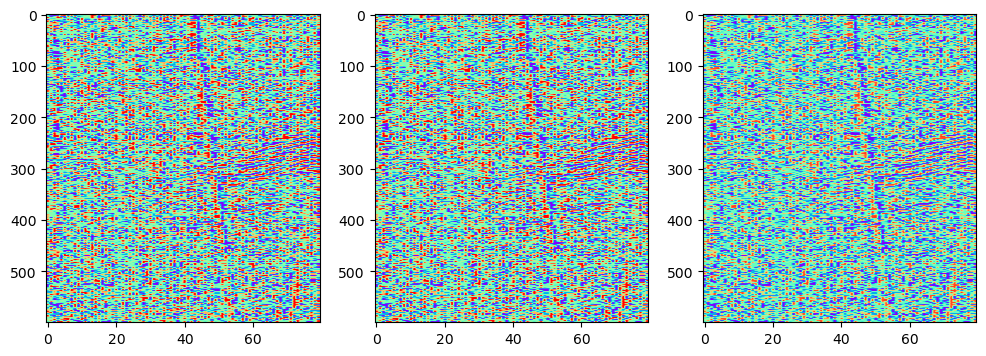

In [28]:
import matplotlib.pyplot as plt


i = 30

vmin1 = np.min(X_train[i])
vmax1 = np.max(X_train[i])
vmin2 = np.min(y_train[i]) 
vmax2 = np.max(y_train[i])
scale = 1


yyy = model(X_train[i:i+1])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize = (12, 4))
ax1.imshow(X_train[i], aspect = 'auto', vmin=scale*vmin1, vmax=scale*vmax1, cmap='rainbow')
ax2.imshow(y_train[i], aspect = 'auto', vmin=scale*vmin2, vmax=scale*vmax2, cmap='rainbow')
ax3.imshow(yyy[0], aspect = 'auto', cmap='rainbow')

In [28]:
yyy[0].numpy().max()

0.0

In [ ]:
class MyClass:
    def __init__(self, name):
        self.name = name

    def __str__(self):
        return f"MyClass object (name: {self.name})"

obj = MyClass("Alice")

In [1]:
!nvidia-smi

Thu Aug  3 14:59:18 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 515.48.07    Driver Version: 515.48.07    CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:D8:00.0  On |                  N/A |
| 58%   48C    P0   119W / 370W |    853MiB / 10240MiB |      3%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------